## Neural Network Classification

The activity shows an example of designing and training a neural network model using TensorFlow.

Reference: https://adventuresinmachinelearning.com/neural-networks-tutorial/, https://www.tensorflow.org/tutorials/quickstart/beginner, https://www.tensorflow.org/tutorials/quickstart/advanced

### Basic Network Training

In [1]:
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

(1797, 64)


<Figure size 432x288 with 0 Axes>

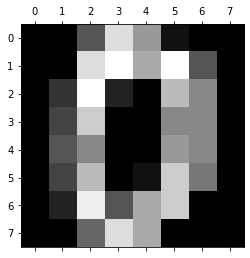

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [2]:
# Load dataset, show data
digits = load_digits()
print(digits.data.shape)
plt.gray() 
plt.matshow(digits.images[0]) 
plt.show()
digits.data[0,:]

In [3]:
# Scale data
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)
X[0,:]

array([ 0.        , -0.33501649, -0.04308102,  0.27407152, -0.66447751,
       -0.84412939, -0.40972392, -0.12502292, -0.05907756, -0.62400926,
        0.4829745 ,  0.75962245, -0.05842586,  1.12772113,  0.87958306,
       -0.13043338, -0.04462507,  0.11144272,  0.89588044, -0.86066632,
       -1.14964846,  0.51547187,  1.90596347, -0.11422184, -0.03337973,
        0.48648928,  0.46988512, -1.49990136, -1.61406277,  0.07639777,
        1.54181413, -0.04723238,  0.        ,  0.76465553,  0.05263019,
       -1.44763006, -1.73666443,  0.04361588,  1.43955804,  0.        ,
       -0.06134367,  0.8105536 ,  0.63011714, -1.12245711, -1.06623158,
        0.66096475,  0.81845076, -0.08874162, -0.03543326,  0.74211893,
        1.15065212, -0.86867056,  0.11012973,  0.53761116, -0.75743581,
       -0.20978513, -0.02359646, -0.29908135,  0.08671869,  0.20829258,
       -0.36677122, -1.14664746, -0.5056698 , -0.19600752])

In [4]:
# Split dataset into train/test
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [5]:
# Convert output to binary (1-hot encoding) vector
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)
y_train[0], y_v_train[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

In [6]:
# Set up the neural network
nn_structure = [64, 30, 10]
def f(x):
    return 1 / (1 + np.exp(-x))
def f_deriv(x):
    return f(x) * (1 - f(x))


The gradient descent algorithm works as follows:

Randomly initialise the weights for each layer $W^{(l)}$.  
While iterations < iteration limit:  
1. Set $\Delta W$ and $\Delta b$ to zero.  
2. For samples 1 to m:  
   a. Perform a feed foward pass through all the $n_l$ layers. Store the activation function outputs $h^{(l)}$.  
   b. Calculate the $\delta^{(n_l)}$ value for the output layer.  
   c. Use backpropagation to calculate the $\delta^{(l)}$ values for layers 2 to $n_l-1$.  
   d. Update the $\Delta W^{(l)}$ and $\Delta b^{(l)}$  for each layer.  
3. Perform a gradient descent step using:  
$W^{(l)} = W^{(l)}-\alpha[\frac{1}{m}\Delta W^{(l)}]$,  
$b^{(l)} = b^{(l)}-\alpha[\frac{1}{m}\Delta b^{(l)}]$.

In [7]:
# Initialize parameters to random values
def setup_and_init_weights(nn_structure):
    W = {}
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1]))
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

def feed_forward(x, W, b):
    h = {1: x}
    z = {}
    for l in range(1, len(W) + 1):
        # if it is the first layer, then the input into the weights is x, otherwise, 
        # it is the output from the last layer
        if l == 1:
            node_in = x
        else:
            node_in = h[l]
        z[l+1] = W[l].dot(node_in) + b[l] # z^(l+1) = W^(l)*h^(l) + b^(l)  
        h[l+1] = f(z[l+1]) # h^(l) = f(z^(l)) 
    return h, z

def calculate_out_layer_delta(y, h_out, z_out):
    # delta^(nl) = -(y_i - h_i^(nl)) * f'(z_i^(nl))
    return -(y-h_out) * f_deriv(z_out)

def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
    W, b = setup_and_init_weights(nn_structure)
    cnt = 0
    m = len(y)
    avg_cost_func = []
    print('Starting gradient descent for {} iterations'.format(iter_num))
    while cnt < iter_num:
        if cnt%1000 == 0:
            print('Iteration {} of {}'.format(cnt, iter_num))
        tri_W, tri_b = init_tri_values(nn_structure)
        avg_cost = 0
        for i in range(len(y)):
            delta = {}
            # perform the feed forward pass and return the stored h and z values, to be used in the
            # gradient descent step
            h, z = feed_forward(X[i, :], W, b)
            # loop from nl-1 to 1 backpropagating the errors
            for l in range(len(nn_structure), 0, -1):
                if l == len(nn_structure):
                    delta[l] = calculate_out_layer_delta(y[i,:], h[l], z[l])
                    avg_cost += np.linalg.norm((y[i,:]-h[l]))
                else:
                    if l > 1:
                        delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                    # triW^(l) = triW^(l) + delta^(l+1) * transpose(h^(l))
                    tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(h[l][:,np.newaxis])) 
                    # trib^(l) = trib^(l) + delta^(l+1)
                    tri_b[l] += delta[l+1]
        # perform the gradient descent step for the weights in each layer
        for l in range(len(nn_structure) - 1, 0, -1):
            W[l] += -alpha * (1.0/m * tri_W[l])
            b[l] += -alpha * (1.0/m * tri_b[l])
        # complete the average cost calculation
        avg_cost = 1.0/m * avg_cost
        avg_cost_func.append(avg_cost)
        cnt += 1
    return W, b, avg_cost_func

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


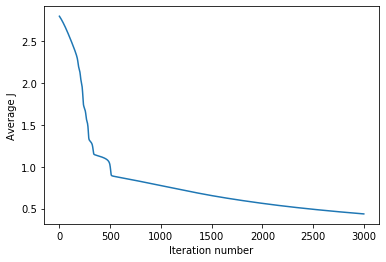

CPU times: user 2min 44s, sys: 383 ms, total: 2min 44s
Wall time: 2min 44s


In [9]:
%%time
# Train model and plot cost function
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train)
plt.plot(avg_cost_func)
plt.ylabel('Average J')
plt.xlabel('Iteration number')
plt.show()

In [10]:
# Assess model performance
def predict_y(W, b, X, n_layers):
    m = X.shape[0]
    y = np.zeros((m,))
    for i in range(m):
        h, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(h[n_layers])
    return y

y_pred = predict_y(W, b, X_test, 3)
accuracy_score(y_test, y_pred)*100

88.17802503477051

### TensorFlow beginner version

In [11]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# load and split dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Stack the layers
tf.keras.backend.set_floatx('float64')
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
predictions = model(x_train[:1]).numpy()
predictions

array([[ 1.72303219e-01,  5.04035710e-01, -2.36671756e-01,
        -1.63559060e-01, -2.40954505e-01, -4.37905302e-01,
        -2.98322534e-04,  9.52206843e-02,  6.72229779e-02,
        -4.81110492e-01]])

In [12]:
# The tf.nn.softmax function converts these logits to "probabilities" for each class
tf.nn.softmax(predictions).numpy()

array([[0.12247447, 0.17065348, 0.08136357, 0.08753514, 0.08101585,
        0.06653273, 0.10305894, 0.11338851, 0.11025792, 0.06371939]])

In [13]:
# The losses.SparseCategoricalCrossentropy loss takes a vector of logits and a True index and returns a scalar loss for each example.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(y_train[:1], predictions).numpy()

2.7100613117218018

In [14]:
%%time
# compile and fit/learn the model
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 0.2997 - accuracy: 0.9120
Epoch 2/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1450 - accuracy: 0.9570
Epoch 3/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.1086 - accuracy: 0.9675
Epoch 4/5
60000/60000 [==============================] - 2s 28us/sample - loss: 0.0876 - accuracy: 0.9728
Epoch 5/5
60000/60000 [==============================] - 2s 29us/sample - loss: 0.0751 - accuracy: 0.9767
CPU times: user 27 s, sys: 3.61 s, total: 30.7 s
Wall time: 8.81 s


In [15]:
# evaluate the model
model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 0s - loss: 0.0694 - accuracy: 0.9788


[0.06937223155732469, 0.9788]

### TensorFlow Advanced

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

# Load and prepare the MNIST dataset.
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# Use tf.data to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Build the tf.keras model using the Keras model subclassing API
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Create an instance of the model
model = MyModel()

# Choose an optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Select metrics to measure the loss and the accuracy of the model.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Use tf.GradientTape to train the model
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
# test the model
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [17]:
%%time
# do the actual training
EPOCHS = 5

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.1345686917601774, Accuracy: 95.97166666666666, Test Loss: 0.0620757358452936, Test Accuracy: 97.91
Epoch 2, Loss: 0.045320465070350716, Accuracy: 98.61333333333333, Test Loss: 0.05382331483114061, Test Accuracy: 98.24000000000001
Epoch 3, Loss: 0.024378025516072134, Accuracy: 99.20833333333333, Test Loss: 0.05122035293223484, Test Accuracy: 98.45
Epoch 4, Loss: 0.01498234855302629, Accuracy: 99.5, Test Loss: 0.0567034374064936, Test Accuracy: 98.4
Epoch 5, Loss: 0.010724055497633648, Accuracy: 99.63, Test Loss: 0.06274510387954933, Test Accuracy: 98.39
CPU times: user 26min 3s, sys: 1min 14s, total: 27min 17s
Wall time: 3min 15s
